In [145]:
from datamarket import *

# Read the data and train model without augmentation
We first use factorized linear regression, then automl.

In summary, R2 score for linear regression is:0.009878592245889273, for automl is: 0.5458767724247864

In [146]:
# read gender from 
gender = pd.read_csv("gender.csv")

# train test split
msk = split_mask(len(gender)) < 0.8
gender_train = gender[msk].copy()
gender_test = gender[~msk].copy()

gender_train_data = agg_dataset()
gender_train_data.load(gender_train, ["Number Tested", "Mean Scale Score"], ["DBN", ["DBN","Grade"], "Year", "Category"], "gender")
gender_train_data.process_target("Mean Scale Score")
gender_train_data.to_numeric_and_impute_all()
gender_train_data.remove_redundant_columns()
gender_train_data.create_count_true()
gender_train_data.compute_agg()

gender_test_data = agg_dataset()
gender_test_data.load(gender_test, ["Number Tested", "Mean Scale Score"], ["DBN", ["DBN","Grade"], "Year", "Category"], "gender")
gender_test_data.process_target("Mean Scale Score")
gender_test_data.to_numeric_and_impute_all()
gender_test_data.remove_redundant_columns()
gender_test_data.create_count_true()
gender_test_data.compute_agg()

In [5]:
# model performance before augmentation with linear regression
train_cov = gender_train_data.covariance
test_cov = gender_test_data.covariance
x = ['gender:Number Tested']
y = 'gender:Mean Scale Score'
parameter = linear_regression(train_cov, x, y)
print("R2 score is:" + str(r2(test_cov, x, y, parameter)))

R2 score is:0.011683490938364849


In [149]:
gender = gender.astype({'DBN': 'category', 'Year': 'category', "Grade": 'category', "Category": 'category'})
gender["Mean Scale Score"] = pd.to_numeric(gender["Mean Scale Score"], errors='coerce')
gender.dropna(subset=["Mean Scale Score"],inplace=True)
msk = split_mask(len(gender)) < 0.8
gender_train = gender[msk].copy()
gender_test = gender[~msk].copy()

In [176]:
len(X_train)

37774

In [206]:
# model performance with autoML 
X_train = gender_train[["Number Tested", "DBN", "Year", "Grade"]]
y_train = gender_train["Mean Scale Score"]
X_test = gender_test[["Number Tested", "DBN", "Year", "Grade"]]
y_test = gender_test["Mean Scale Score"]

automl = autosklearn.regression.AutoSklearnRegressor(
    time_left_for_this_task=300,
    per_run_time_limit=100,
    memory_limit=6072
)
automl.fit(X_train, y_train, X_test, y_test, dataset_name='gender')

[WARNING] [2022-03-24 06:33:31,465:Client-EnsembleBuilder] No models better than random - using Dummy loss!Number of models besides current dummy model: 1. Number of dummy models: 1
[WARNING] [2022-03-24 06:33:51,782:Client-EnsembleBuilder] No models better than random - using Dummy loss!Number of models besides current dummy model: 1. Number of dummy models: 1


AutoSklearnRegressor(memory_limit=6072, per_run_time_limit=100,
                     time_left_for_this_task=300)

In [207]:
now = datetime.now()
now_n = now
current_time = now_n.strftime("%H:%M:%S")
print("Current Time =", current_time)

Current Time = 06:38:03


Train R2 score: 0.6796685933884079
Test R2 score: 0.5421658694690988
          rank  ensemble_weight               type    cost   duration
model_id                                                             
4            1              1.0  gradient_boosting  0.4601  22.299047
                   Timestamp  ensemble_optimization_score  \
3 2022-03-24 06:33:31.000000                          NaN   
0 2022-03-24 06:33:31.537233                    -0.000206   
4 2022-03-24 06:34:14.000000                    -0.000206   
5 2022-03-24 06:34:14.000000                    -0.000206   
6 2022-03-24 06:34:14.000000                    -0.000206   
1 2022-03-24 06:34:14.300122                     0.539900   
2 2022-03-24 06:34:14.300122                     0.539900   

   ensemble_test_score  single_best_optimization_score  \
3                  NaN                       -0.046017   
0            -0.000027                       -0.046017   
4            -0.000027                        0.539900   


<AxesSubplot:title={'center':'Auto-sklearn accuracy over time'}, xlabel='Timestamp'>

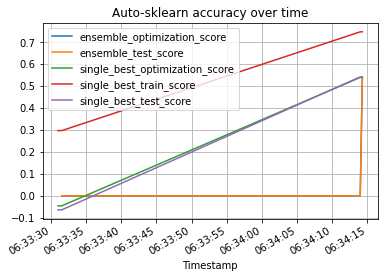

In [208]:
train_predictions = automl.predict(X_train)
print("Train R2 score:", sklearn.metrics.r2_score(y_train, train_predictions))
test_predictions = automl.predict(X_test)
print("Test R2 score:", sklearn.metrics.r2_score(y_test, test_predictions))
print(automl.leaderboard())
poT = automl.performance_over_time_
print(poT)
poT.plot(
    x='Timestamp',
    kind='line',
    legend=True,
    title='Auto-sklearn accuracy over time',
    grid=True,
)

In [209]:
poT1 = automl.performance_over_time_

In [212]:
poT1["duration"] = [t.total_seconds() + 300 for t in(poT1["Timestamp"] - now_n)]

In [213]:
poT1[["ensemble_test_score", "duration"]]

,ensemble_test_score,duration
3,NaN,27.675201
0,-0.000027,28.212434
4,-0.000027,70.675201
5,-0.000027,70.675201
6,-0.000027,70.675201
1,0.542166,70.975323
2,0.542166,70.975323


In [214]:
poT1[["ensemble_test_score", "duration"]].to_csv("automl_naive_300_100.csv",index=False)

In [239]:
poT2["duration"] = [t.total_seconds() + 310 for t in(poT2["Timestamp"] - now_aug)]
# poT2["duration2"] = [t.total_seconds() + 820 for t in(poT2["Timestamp"] - now_aug)]
poT2.fillna(0, inplace=True)

In [240]:
poT2[["ensemble_test_score", "duration"]]

,ensemble_test_score,duration
0,-9.158032e-07,57.354909
4,-9.158032e-07,174.615479
1,6.611305e-01,174.769722
5,6.611305e-01,294.615479
6,6.611305e-01,294.615479
2,7.476685e-01,295.862020
3,7.476685e-01,295.862020


In [241]:
poT2[["ensemble_test_score", "duration"]].to_csv("automl_result_market_300_100.csv",index=False)

In [52]:
poT1[["ensemble_test_score", "duration"]].to_csv("automl_result2.csv",index=False)

Train R2 score: 0.6760717762409097
Test R2 score: 0.5458767724247864
          rank  ensemble_weight               type      cost   duration
model_id                                                               
5            1              1.0  gradient_boosting  0.464419  22.770549
                   Timestamp  ensemble_optimization_score  \
2 2022-03-10 22:13:35.000000                          NaN   
0 2022-03-10 22:13:35.715064                    -0.000025   
3 2022-03-10 22:15:57.000000                    -0.000025   
1 2022-03-10 22:15:57.711512                     0.535581   

   ensemble_test_score  single_best_optimization_score  \
2                  NaN                       -0.065672   
0            -0.000010                       -0.065672   
3            -0.000010                        0.535581   
1             0.545877                        0.535581   

   single_best_train_score  single_best_test_score  
2                 0.293797               -0.055145  
0           

<AxesSubplot:title={'center':'Auto-sklearn accuracy over time'}, xlabel='Timestamp'>

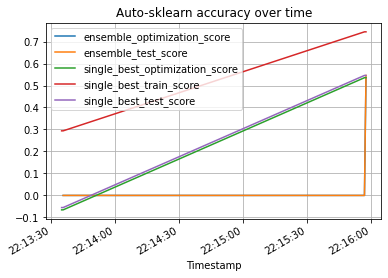

In [125]:
train_predictions = automl.predict(X_train)
print("Train R2 score:", sklearn.metrics.r2_score(y_train, train_predictions))
test_predictions = automl.predict(X_test)
print("Test R2 score:", sklearn.metrics.r2_score(y_test, test_predictions))
print(automl.leaderboard())
poT = automl.performance_over_time_
print(poT)
poT.plot(
    x='Timestamp',
    kind='line',
    legend=True,
    title='Auto-sklearn accuracy over time',
    grid=True,
)

# Load seller datasets and build market
Currently, we need to specify the join attributes (could be joined on multiple attributes) and these attributes name have to be same across two tables.

We need more data.

The best data increase linear regression R2 to 0.3944023420421897

This data also increase automl R2 to: 0.7970338954417067

In [153]:
# read buyer dataste
crime = pd.read_csv("crime.csv")
crimedata = agg_dataset()
crimedata.load(crime, [], ["DBN"], "crime")
crimedata.find_features()
crimedata.remove_redundant_columns()
crimedata.create_count_true()
crimedata.compute_agg(True)


esl = pd.read_csv("esl.csv")
esldata = agg_dataset()
esldata.load(esl, [], [["DBN","Grade"]], "esl")
esldata.find_features()
esldata.remove_redundant_columns()
esldata.create_count_true()
esldata.compute_agg(True)

ap = pd.read_csv("ap.csv")
apdata = agg_dataset()
apdata.load(ap, [], ["DBN"], "ap")
apdata.find_features()
apdata.remove_redundant_columns()
apdata.create_count_true()
apdata.compute_agg(True)

survey = pd.read_csv("2013_NYC_School_Survey.csv")
surveydata = agg_dataset()
surveydata.load(survey, [], ["DBN"], "survey")
surveydata.find_features()
surveydata.remove_redundant_columns()
surveydata.create_count_true()
surveydata.compute_agg(True)

base = pd.read_csv("base.csv")
basedata = agg_dataset()
basedata.load(base, [], ["DBN"], "base")
basedata.find_features()
basedata.remove_redundant_columns()
basedata.create_count_true()
basedata.compute_agg(True)

disc = pd.read_csv("disc.csv")
discdata = agg_dataset()
discdata.load(disc, [], ["DBN"], "disc")
discdata.find_features()
discdata.remove_redundant_columns()
discdata.create_count_true()
discdata.compute_agg(True)

math = pd.read_csv("math.csv")
mathdata = agg_dataset()
mathdata.load(math, [], [["DBN","Grade"]], "math")
mathdata.find_features()
mathdata.remove_redundant_columns()
mathdata.create_count_true()
mathdata.compute_agg(True)

oss = pd.read_csv("oss.csv")
ossdata = agg_dataset()
ossdata.load(oss, [], ["DBN"], "oss")
ossdata.find_features()
ossdata.remove_redundant_columns()
ossdata.create_count_true()
ossdata.compute_agg(True)

pe = pd.read_csv("pe.csv")
pedata = agg_dataset()
pedata.load(pe, [], ["DBN"], "pe")
pedata.find_features()
pedata.remove_redundant_columns()
pedata.create_count_true()
pedata.compute_agg(True)

s2tr = pd.read_csv("s2tr.csv")
s2trdata = agg_dataset()
s2trdata.load(s2tr, [], ["DBN"], "s2tr")
s2trdata.find_features()
s2trdata.remove_redundant_columns()
s2trdata.create_count_true()
s2trdata.compute_agg(True)

sat = pd.read_csv("sat.csv")
satdata = agg_dataset()
satdata.load(sat, [], ["DBN"], "sat")
satdata.find_features()
satdata.remove_redundant_columns()
satdata.create_count_true()
satdata.compute_agg(True)

pro = pd.read_csv("Schools_Progress_Report_2012-2013.csv")
prodata = agg_dataset()
prodata.load(pro, [], ["DBN"], "pro")
prodata.find_features()
prodata.remove_redundant_columns()
prodata.create_count_true()
prodata.compute_agg(True)


spy = pd.read_csv("spy.csv")
spydata = agg_dataset()
spydata.load(spy, [], ["Year"], "spy")
spydata.find_features()
spydata.remove_redundant_columns()
spydata.create_count_true()
spydata.compute_agg(True)

transfer = pd.read_csv("transfer.csv")
transferdata = agg_dataset()
transferdata.load(transfer, [], ["DBN"], "transfer")
transferdata.find_features()
transferdata.remove_redundant_columns()
transferdata.create_count_true()
transferdata.compute_agg(True)

yabc = pd.read_csv("yabc.csv")
yabcdata = agg_dataset()
yabcdata.load(yabc, [], ["DBN"], "yabc")
yabcdata.find_features()
yabcdata.remove_redundant_columns()
yabcdata.create_count_true()
yabcdata.compute_agg(True)

dm1 = pd.read_csv("other/datamart.socrata.data-cityofnewyork-us.22rr-ujq3")
dm1data = agg_dataset()
dm1data.load(dm1, [], ["DBN"], "dm1")
dm1data.find_features()
dm1data.remove_redundant_columns()
dm1data.create_count_true()
dm1data.compute_agg(True)

dm2 = pd.read_csv("other/datamart.socrata.data-cityofnewyork-us.25aa-q86c")
dm2data = agg_dataset()
dm2data.load(dm2, [], ["DBN"], "dm2")
dm2data.find_features()
dm2data.remove_redundant_columns()
dm2data.create_count_true()
dm2data.compute_agg(True)

dm3 = pd.read_csv("other/datamart.socrata.data-cityofnewyork-us.29bv-qqsy")
dm3data = agg_dataset()
dm3data.load(dm3, [], ["DBN"], "dm3")
dm3data.find_features()
dm3data.remove_redundant_columns()
dm3data.create_count_true()
dm3data.compute_agg(True)

dm4 = pd.read_csv("other/datamart.socrata.data-cityofnewyork-us.29ry-u5bf")
dm4data = agg_dataset()
dm4data.load(dm4, [], ["DBN"], "dm4")
dm4data.find_features()
dm4data.remove_redundant_columns()
dm4data.create_count_true()
dm4data.compute_agg(True)

dm5 = pd.read_csv("other/datamart.socrata.data-cityofnewyork-us.43qc-8vv8")
dm5data = agg_dataset()
dm5data.load(dm5, [], [["DBN","Grade"]], "dm5")
dm5data.find_features()
dm5data.remove_redundant_columns()
dm5data.create_count_true()
dm5data.compute_agg(True)

/home/jupyter/arda/arda-datasets/school/datamarket.py:201: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.data['cov:Q:' + tablename + ":" + attributes[i] + ","+ tablename + ":" + attributes[j]] = self.data[attributes[i]] * self.data[attributes[j]]


In [4]:

math = pd.read_csv("math.csv")
mathdata = agg_dataset()
mathdata.load(math, [], [["DBN","Grade"]], "math")
mathdata.find_features()
mathdata.remove_redundant_columns()
mathdata.compute_agg(True)


In [218]:
# %%time
sellers = [(crimedata, "DBN"), (apdata, "DBN"), (surveydata, "DBN"), 
           (basedata, "DBN"), (discdata, "DBN"), (mathdata, ("DBN","Grade")), 
           (ossdata, "DBN"), (pedata, "DBN"), (s2trdata, "DBN"), 
           (satdata, "DBN"), (prodata, "DBN"), (spydata, "Year"),
           (transferdata, "DBN"), (yabcdata, "DBN"), (dm1data, "DBN"),
           (dm2data, "DBN"), (dm3data, "DBN"), (dm4data, "DBN"), (dm5data, ("DBN","Grade"))]

# sellers = [(mathdata, ("DBN","Grade"))]


# find m best datasets to augment
bought = set()
cache_augs = dict()
cache_augs[(gender_train.name, gender_train.columns)] = []
m = 2
y = "Mean Scale Score"

for i in range(m):
    best_seller = None
    best_seller_attrs = []
    best_dimension = None
    best_r2 = 0

    for sellerdata, dimension in sellers:
        # check if current seller has been bought
        if sellerdata.name in gender_train_data.datasets:
            continue
        print(sellerdata.name)

        # find the attributes and r2 of augmenting
        cur_atts, final_r2 = select_features(gender_train_data, gender_test_data, sellerdata, dimension, 4, y)
#         cur_atts, final_r2 = select_features(gender_train, gender_test, sellerdata, dimension,10)

        if final_r2 > best_r2:
            best_seller = sellerdata
            best_dimension = dimension
            best_seller_attrs = cur_atts
            best_r2 = final_r2


    print(best_seller.name, best_seller_attrs, best_r2)
    
    true_absorb = True
    budget = 100000
    
    # there is no attributes that is predictive in seller dataset
    if len([x for x in best_seller_attrs if x in best_seller.X]) == 0:
        true_absorb = False
    else:
        count_true_join = connect_count(gender_train_data, best_seller, best_dimension)
        if count_true_join["cov:c"].sum() > budget:
            print("beyond budget!!")
            true_absorb = False
        else:
            gender_train_data.count_true = count_true_join
            gender_train_data.count_true.reset_index(inplace=True)
    
    if not true_absorb:
        gender_train_data.datasets.add(best_seller.name)
        gender_test_data.datasets.add(best_seller.name)
    else:
        gender_train_data.absorb(best_seller, best_dimension, best_seller_attrs + [gender_train_data.name + ":" + y])
        gender_test_data.absorb(best_seller, best_dimension, best_seller_attrs + [gender_train_data.name + ":" + y])
        #I interpret this as: the market successfully used this seller, so we should add them to the cache
        #store the buyer's schema
        cache_augs[(gender_train.name, gender_train.columns)].append((best_seller, best_dimension, best_seller_attrs))
        

crime
ap
survey
base
disc
math


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:383: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


oss
pe
s2tr
sat
pro
spy
transfer
yabc
dm1
dm2
dm3
dm4
dm5
math ['math:Level 4 %', 'math:Level 1 %', 'math:Year', 'math:Mean Scale Score'] 0.3913151214912982


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:328: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:329: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


beyond budget!!
crime
ap
survey
base
disc
oss
pe
s2tr
sat
pro
spy
transfer
yabc
dm1
dm2
dm3
dm4
dm5
pro ['pro:2012-2013 PERFORMANCE CATEGORY SCORE', 'pro:2012-2013 ADDITIONAL CREDIT', 'pro:DISTRICT', 'pro:2012-2013 PROGRESS CATEGORY SCORE'] 0.38052262018298766


In [216]:
# gender_train_data.count_true.groupby(['DBN', 'Grade']).sum()
# connect_count(gender_train_data, mathdata, ('DBN', 'Grade'))["cov:c"].sum()
gender_train_data.count_true["cov:c"].sum()

40177.0

In [58]:
%%time
c=connect(gender_train_data, mathdata, ("DBN","Grade"))

CPU times: user 98.2 ms, sys: 573 µs, total: 98.8 ms
Wall time: 96.1 ms


In [132]:
best_dimension = ['DBN', 'Grade']

'DBN'

In [225]:
# make best_dimension a list
if isinstance(best_dimension, tuple):
    best_dimension = list(best_dimension)
else:
    best_dimension = [best_dimension]

# extract needed attributes
seller_features = ['cov:s:' +  attr for attr in best_seller_attrs  if attr.startswith(best_seller.name)]
buyer_features = ['cov:s:' +  attr for attr in best_seller_attrs  if not attr.startswith(best_seller.name)]
target = ['cov:s:gender:' + y]
buyer_train_data = gender_train_data.data[gender_train_data.dedup_dimensions + buyer_features + target]
buyer_test_data = gender_test_data.data[gender_train_data.dedup_dimensions + buyer_features + target]
seller_data = best_seller.data[best_dimension + seller_features]
# seller_data = seller_data.groupby(best_dimension).mean()

# join buyer and seller
join_train = pd.merge(buyer_train_data,seller_data,how='left', on=best_dimension)
join_test = pd.merge(buyer_test_data,seller_data,how='left', on=best_dimension)

In [159]:
join_train

,Grade,Year,Category,DBN,cov:s:gender:Mean Scale Score,cov:s:pro:2012-2013 PERFORMANCE CATEGORY SCORE,cov:s:pro:2012-2013 ADDITIONAL CREDIT,cov:s:pro:DISTRICT,cov:s:pro:2012-2013 PROGRESS CATEGORY SCORE
0,3,2013,Male,01M015,292.0,6.100000,4.400000,1.0,30.300000
1,3,2015,Female,01M015,289.0,6.100000,4.400000,1.0,30.300000
2,3,2015,Male,01M015,276.0,6.100000,4.400000,1.0,30.300000
3,3,2017,Female,01M015,308.0,6.100000,4.400000,1.0,30.300000
4,3,2017,Male,01M015,297.0,6.100000,4.400000,1.0,30.300000
...,...,...,...,...,...,...,...,...,...
40172,All Grades,2015,Male,32K562,274.0,12.668492,3.915805,32.0,30.172677
40173,All Grades,2016,Female,32K562,286.0,12.668492,3.915805,32.0,30.172677
40174,All Grades,2016,Male,32K562,282.0,12.668492,3.915805,32.0,30.172677
40175,All Grades,2017,Female,32K562,289.0,12.668492,3.915805,32.0,30.172677


In [9]:
# missing value imputation
for attr in best_seller_attrs:
    if attr in best_seller.covariance:
        join_train["cov:s:" + attr].fillna(best_seller.covariance["cov:s:" + attr], inplace=True)
        join_test["cov:s:" + attr].fillna(best_seller.covariance["cov:s:" + attr], inplace=True)

In [10]:
def one_one_encoding(relation, attributes):
    one_hot_encoding_relations = [relation]
    for attr in attributes:
        one_hot_encoding_relations.append(pd.get_dummies(relation[attr], prefix=attr))
    encoded_relation = pd.concat(one_hot_encoding_relations, axis=1)
    encoded_relation.drop(columns=attributes, inplace=True)
    return encoded_relation

# join_train = one_one_encoding(join_train, gender_train_data.dedup_dimensions)
# join_test = one_one_encoding(join_test, gender_train_data.dedup_dimensions)

In [11]:
join_train_len = len(join_train)
join = pd.concat([join_train, join_test])
join = one_one_encoding(join, gender_train_data.dedup_dimensions)
join_train = join.iloc[:join_train_len]
join_test = join.iloc[join_train_len:]

In [13]:
join.to_csv("math_gender_join.csv", index=False)

In [96]:
# join_train = join_train[['cov:s:gender:Mean Scale Score','cov:s:math:Level 4 %', 'cov:s:math:Level 1 %', 'cov:s:math:Year','cov:s:math:Mean Scale Score']]
# join_test = join_test[['cov:s:gender:Mean Scale Score','cov:s:math:Level 4 %', 'cov:s:math:Level 1 %', 'cov:s:math:Year','cov:s:math:Mean Scale Score']]

In [220]:
y_train = join_train[target]
y_test = join_test[target]
X_train = join_train.drop(columns=target)
X_test = join_test.drop(columns=target)

In [16]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

In [119]:
for att in X_train.columns:
    if att not in X_test.columns:
        print(att)

In [86]:
%%time
clf = GradientBoostingClassifier(n_estimators=1, max_leaf_nodes=8).fit(X_train, y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


CPU times: user 1min 21s, sys: 11.5 s, total: 1min 33s
Wall time: 1min 33s


In [36]:
len(X_train)

201535

In [54]:
%%time
clf = RandomForestClassifier(max_depth = 20,random_state=1, n_estimators=100)
clf.fit(X_train, y_train)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


CPU times: user 58 s, sys: 1.75 s, total: 59.7 s
Wall time: 59.7 s


RandomForestClassifier(max_depth=20, random_state=1)

In [21]:
clf.predict(X_test)

array([294., 294., 294., ..., 294., 294., 294.])

In [22]:
from sklearn.metrics import r2_score

In [55]:
r2_score(y_test, clf.predict(X_test))

0.6030808485885308

In [ ]:
print("hi")


In [41]:
from math import log

In [57]:
len(X_train.columns)

1156

In [52]:
log(201535)* 201535 /log(10000)/10000

26.725306848120603

In [226]:
join_train = join_train.astype({'DBN': 'category', 'Year': 'category', "Grade": 'category', "Category": 'category'})
join_test = join_test.astype({'DBN': 'category', 'Year': 'category', "Grade": 'category', "Category": 'category'})

In [230]:
%%time
# model performance with autoML 
X_train = join_train[["Number Tested", "DBN", "Year", "Grade"] + seller_features + buyer_features]
y_train = join_train[target]
X_test = join_test[["Number Tested", "DBN", "Year", "Grade"] + seller_features + buyer_features]
y_test = join_test[target]

automl = autosklearn.regression.AutoSklearnRegressor(
    time_left_for_this_task=300,
    per_run_time_limit=100,
    memory_limit=6072
)
automl.fit(X_train, y_train, X_test, y_test, dataset_name='gender')

CPU times: user 1.01 s, sys: 1.58 s, total: 2.59 s
Wall time: 4min 57s


AutoSklearnRegressor(memory_limit=6072, per_run_time_limit=100,
                     time_left_for_this_task=300)

In [231]:
now = datetime.now()
now_aug = now
current_time = now_aug.strftime("%H:%M:%S")
print("Current Time =", current_time)

Current Time = 06:46:50


Train R2 score: 0.83602551905231
Test R2 score: 0.747668461987619
          rank  ensemble_weight         type      cost   duration
model_id                                                         
6            1             0.84  extra_trees  0.248219  71.429998
4            2             0.16  extra_trees  0.334160  15.901814
                   Timestamp  ensemble_optimization_score  \
0 2022-03-24 06:42:37.739430                    -0.000003   
4 2022-03-24 06:44:35.000000                    -0.000003   
1 2022-03-24 06:44:35.154243                     0.665840   
5 2022-03-24 06:46:35.000000                     0.665840   
6 2022-03-24 06:46:35.000000                     0.665840   
2 2022-03-24 06:46:36.246541                     0.755464   
3 2022-03-24 06:46:36.246541                     0.755464   

   ensemble_test_score  single_best_optimization_score  \
0        -9.158032e-07                             NaN   
4        -9.158032e-07                        0.665840   
1      

<AxesSubplot:title={'center':'Auto-sklearn accuracy over time'}, xlabel='Timestamp'>

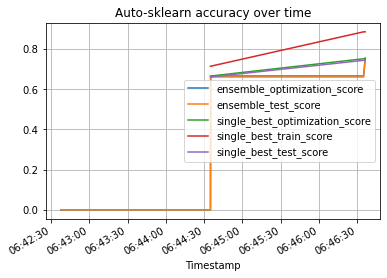

In [232]:
train_predictions = automl.predict(X_train)
print("Train R2 score:", sklearn.metrics.r2_score(y_train, train_predictions))
test_predictions = automl.predict(X_test)
print("Test R2 score:", sklearn.metrics.r2_score(y_test, test_predictions))
print(automl.leaderboard())
poT = automl.performance_over_time_
print(poT)
poT.plot(
    x='Timestamp',
    kind='line',
    legend=True,
    title='Auto-sklearn accuracy over time',
    grid=True,
)

In [234]:
poT2 = poT 

Train R2 score: 0.8417184044415904
Test R2 score: 0.7970338954417067
          rank  ensemble_weight               type      cost   duration
model_id                                                               
4            1              1.0  gradient_boosting  0.181931  175.89374
                   Timestamp  ensemble_optimization_score  \
0 2022-03-11 00:09:47.064354                    -0.000038   
2 2022-03-11 00:17:43.000000                    -0.000038   
1 2022-03-11 00:17:43.318110                     0.818069   

   ensemble_test_score  single_best_optimization_score  \
0            -0.000036                             NaN   
2            -0.000036                        0.818069   
1             0.797034                        0.818069   

   single_best_train_score  single_best_test_score  
0                      NaN                     NaN  
2                 0.853446                0.797034  
1                 0.853446                0.797034  


<AxesSubplot:title={'center':'Auto-sklearn accuracy over time'}, xlabel='Timestamp'>

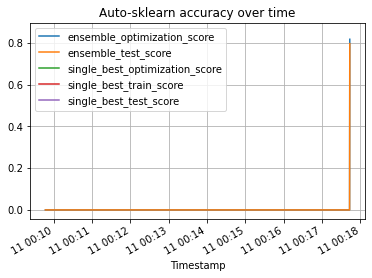

In [242]:
train_predictions = automl.predict(X_train)
print("Train R2 score:", sklearn.metrics.r2_score(y_train, train_predictions))
test_predictions = automl.predict(X_test)
print("Test R2 score:", sklearn.metrics.r2_score(y_test, test_predictions))
print(automl.leaderboard())
poT = automl.performance_over_time_
print(poT)
poT.plot(
    x='Timestamp',
    kind='line',
    legend=True,
    title='Auto-sklearn accuracy over time',
    grid=True,
)

In [115]:
poT2 = automl.performance_over_time_

In [119]:
poT2["Timestamp"] - min(poT2["Timestamp"])

0          0 days 00:00:00
5   0 days 00:02:30.958160
6   0 days 00:02:30.958160
1   0 days 00:02:31.712754
2   0 days 00:02:45.958601
7   0 days 00:05:02.958160
8   0 days 00:05:02.958160
3   0 days 00:05:03.972905
4   0 days 00:05:03.972905
Name: Timestamp, dtype: timedelta64[ns]

In [120]:
automl.sprint_statistics()

'auto-sklearn results:\n  Dataset name: gender\n  Metric: r2\n  Best validation score: 0.692699\n  Number of target algorithm runs: 9\n  Number of successful target algorithm runs: 4\n  Number of crashed target algorithm runs: 0\n  Number of target algorithms that exceeded the time limit: 2\n  Number of target algorithms that exceeded the memory limit: 3\n'